In [1]:
import os, warnings, torch

import torch.nn as nn
import scanpy as sc
import pandas as pd

from model.nicheTrans_ct_attribution_STARmap_PLUS import *
from datasets.data_manager_STARmap_PLUS import AD_Mouse

from utils.utils import *
from utils.utils_dataloader import *
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
%run ./args/args_STARmap_PLUS.py
args = args

### Load dataset

In [3]:
# create the dataloaders
dataset = AD_Mouse(AD_adata_path=args.AD_adata_path, Wild_type_adata_path=args.Wild_type_adata_path, n_top_genes=args.n_top_genes)
_, testloader, valloader = ad_mouse_dataloader(args, dataset)

------Calculating spatial graph...
The graph contains 124464 edges, 10372 cells.
12.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 115608 edges, 9634 cells.
12.0000 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 96408 edges, 8034 cells.
12.0000 neighbors per cell on average.
=> AD Mouse loaded
Dataset statistics:
  ------------------------------
  subset   | # num | 
  ------------------------------
  train    |  10372 spots, 894.0 positive tao, 291.0 positive plaque 
  test     |   9634 spots, 620.0 positive tao, 195.0 positive plaque 
  ------------------------------


### Load model

In [4]:
# create the model
source_dimension, target_dimension = dataset.rna_length, dataset.target_length
model = NicheTrans_ct(source_length=source_dimension, target_length=target_dimension, noise_rate=args.noise_rate, dropout_rate=args.dropout_rate)
model = nn.DataParallel(model).cuda()

model.load_state_dict(torch.load('NicheTrans_*_STARmap_PLUS.pth'))
model.eval() 

DataParallel(
  (module): NicheTrans_ct(
    (encoder_rna): NetBlock(
      (noise_dropout): Dropout(p=0.5, inplace=False)
      (linear_list): ModuleList(
        (0): Linear(in_features=1719, out_features=512, bias=True)
        (1): Linear(in_features=512, out_features=256, bias=True)
      )
      (bn_list): ModuleList(
        (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation_list): ModuleList(
        (0-1): 2 x LeakyReLU(negative_slope=0.01)
      )
      (dropout_list): ModuleList(
        (0): Dropout(p=0.25, inplace=False)
      )
    )
    (projection_rna): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (2): ReLU(inplace=True)
    )
    (fusion_omic): Self_Attention(
      (to_q): Sequential(
        (0): Linear(in_features

### Inference 

In [5]:
inputs_list = []

with torch.no_grad():
    for _, (rna, protein, cell, rna_neighbor, cell_neighbor, _) in enumerate(testloader):

        rna, protein, cell, rna_neighbor, cell_neighbor = rna.cuda(), protein.cuda(), cell.cuda(), rna_neighbor.cuda(), cell_neighbor.cuda()
        cell_inf = torch.cat([cell[:, None, :], cell_neighbor], dim=1)
        omics = torch.cat([rna[:, None, :], rna_neighbor], dim=1)

        temp_length = cell_inf.size(-1)

        temp_input = torch.cat([omics, cell_inf], dim=2)

        outputs = model(temp_input)
        outputs = torch.sigmoid(outputs)
        
        ###########
        # change this threshold to involve more samples
        mask = outputs[:, 0] >0.05

        inputs_list.append(temp_input[mask])

inputs_list = torch.cat(inputs_list, dim=0)

### Calculate and Visualize the gradients

In [6]:
# do the gradient calculation
from captum.attr import IntegratedGradients

ig = IntegratedGradients(model)

baseline = torch.zeros_like(inputs_list).cuda()

# Compute attributions
attributions = ig.attribute(inputs_list, baseline, target=0) 
attributions = attributions.detach().cpu().numpy()

attributions = np.abs(attributions)
grad_norm = attributions.sum(axis=0).sum(axis=0)[-13:]

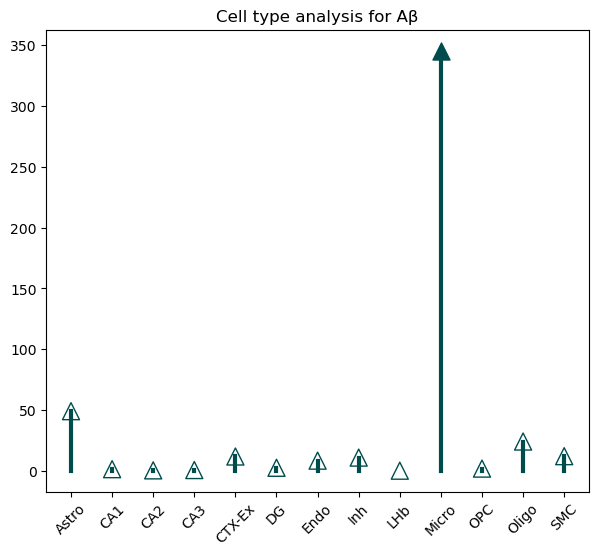

: 

In [ ]:
cell_types = dataset.cell_mask

plt.figure(figsize=(7, 6))

data = pd.DataFrame({
    'Category': cell_types.tolist(),
    'Value': grad_norm
})

max_index = np.argmax(grad_norm)

for i in range(len(data)):
    plt.plot([data['Category'][i], data['Category'][i]], [0, data['Value'][i]], color='#004c4c', linewidth=3)

for i in range(len(data)):
    if i == max_index:
        plt.scatter(data['Category'][i], data['Value'][i], color='#004c4c', s=150, marker='^')
    else:
        plt.scatter(data['Category'][i], data['Value'][i], edgecolors='#004c4c', facecolors='none', s=150, marker='^')

plt.title('Cell type analysis for Aβ')
plt.grid(False)
plt.xticks(rotation=45)

plt.savefig('abeta_cell.eps', format='eps', bbox_inches='tight', dpi=300)  
plt.savefig('abeta_cell.png', format='png', bbox_inches='tight', dpi=300)